In [117]:
import pandas as pd
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

### 50% На основании данных рейтинга top500 спрогнозировать  производительность компьютера №1 в 2025

In [79]:
test = pd.read_json('top500.json') #спасибо коллегам с MADE за json c погодовой производительностю топ 1 суперкомьютеров
test

,1993-06-01,1993-11-01,1994-06-01,1994-11-01,1995-06-01,1995-11-01,1996-06-01,1996-11-01,1997-06-01,1997-11-01,...,2017-11-01,2018-06-01,2018-11-01,2019-06-01,2019-11-01,2020-06-01,2020-11-01,2021-06-01,2021-11-01,2022-06-01
Sum,"[1100.0, GFlop/s]","[1500.0, GFlop/s]","[2300.0, GFlop/s]","[2700.0, GFlop/s]","[3900.0, GFlop/s]","[4800.0, GFlop/s]","[5900.0, GFlop/s]","[8000.0, GFlop/s]","[12800.0, GFlop/s]","[16900.0, GFlop/s]",...,"[849600000.0, GFlop/s]","[1200000000.0, GFlop/s]","[1400000000.0, GFlop/s]","[1600000000.0, GFlop/s]","[1600000000.0, GFlop/s]","[2200000000.0, GFlop/s]","[2400000000.0, GFlop/s]","[2800000000.0, GFlop/s]","[3000000000.0, GFlop/s]","[4400000000.0, GFlop/s]"
#1,"[59.7, GFlop/s]","[124.0, GFlop/s]","[143.4, GFlop/s]","[170.0, GFlop/s]","[170.0, GFlop/s]","[170.0, GFlop/s]","[220.4, GFlop/s]","[368.2, GFlop/s]","[1100.0, GFlop/s]","[1300.0, GFlop/s]",...,"[93000000.0, GFlop/s]","[122300000.0, GFlop/s]","[143500000.0, GFlop/s]","[148600000.0, GFlop/s]","[148600000.0, GFlop/s]","[415500000.0, GFlop/s]","[442000000.0, GFlop/s]","[442000000.0, GFlop/s]","[442000000.0, GFlop/s]","[1100000000.0, GFlop/s]"
#500,"[0.4, GFlop/s]","[0.5, GFlop/s]","[0.8, GFlop/s]","[1.2, GFlop/s]","[2.0, GFlop/s]","[2.5, GFlop/s]","[3.3, GFlop/s]","[4.6, GFlop/s]","[7.7, GFlop/s]","[9.5, GFlop/s]",...,"[548700.0, GFlop/s]","[715600.0, GFlop/s]","[874800.0, GFlop/s]","[1000000.0, GFlop/s]","[1100000.0, GFlop/s]","[1200000.0, GFlop/s]","[1300000.0, GFlop/s]","[1500000.0, GFlop/s]","[1600000.0, GFlop/s]","[1600000.0, GFlop/s]"


<AxesSubplot:>

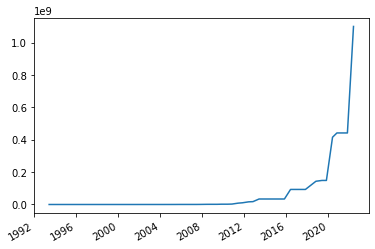

In [85]:
performance = test.loc['#1'].apply(lambda x: x[0])
performance.plot()

Возьмем простую экстраполирующую модель - по типу Аримы.
Также, преобразуем наш датасет в формат стационарного ряда, а именно - не абсолютное значение, а разницу между прошлым и текущим значением (прирост, падение)

In [108]:
def inverse_pct(pct, first_value):
    return pd.Series((np.concatenate([np.zeros((1,)), pct]) + 1).cumprod()) * first_value

<AxesSubplot:>

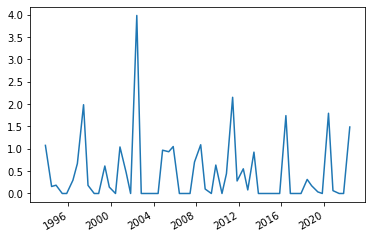

In [120]:
first_value = performance.iloc[0]
pct_performance = performance.pct_change()[1:] #первое значние это nan
pct_performance.plot()

<AxesSubplot:>

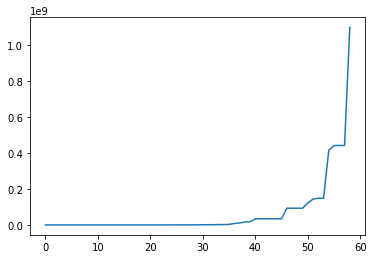

In [121]:
inverse_pct(pct_performance, first_value=first_value).plot()

/Users/18843024/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/18843024/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/18843024/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/18843024/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is a

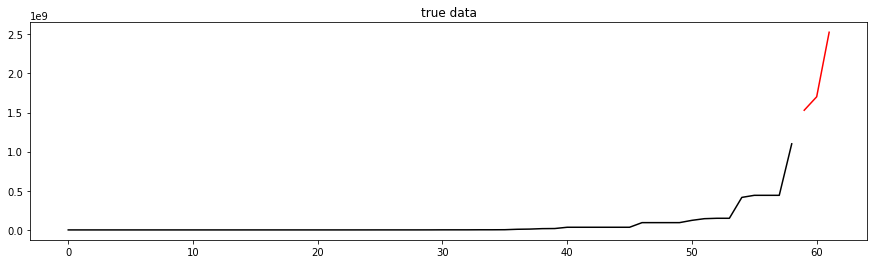

In [260]:
simple_model = sm.tsa.SARIMAX(pct_performance, order=(1, 0, 1)).fit(disp=0)
sims = simple_model.simulate(3, anchor='end', repetitions = 1)
#Добавляем прогноз в временной ряд
ts = pd.concat([pct_performance.reset_index(drop=True), pd.Series([i[0] for i in sims.values])], axis = 0).reset_index(drop=True)
ts = inverse_pct(ts, first_value=first_value)
fig, ax = plt.subplots(figsize=(15, 4))
ts[-3:].plot(color='r', ax=ax, title = 'forecast')
ts[:-3].plot(ax=ax, color='k', alpha=1.0, legend=False, title='true data')
plt.show()
#tmp_test.plot(color='r', ax=ax);

In [261]:
forecast  = ts[-3:]
forecast

59    1.528944e+09
60    1.701116e+09
61    2.525538e+09
dtype: float64

### 50% оцените какой процент всего производимого на Земле электричества потребляют все компьютеры из top500 (на основании открытых данных top500.org)

Предположим что все компьютеры работают целый год. В году условно 365 дней, 24 часа в сутках, 60 минут в часах и 60 секунд в минуте, итого получаем в году - 365*24*60*60 = 31536000 секунд.
Мы можем предположить сколько всего энергии было затрачено в году по cредней максимальную производительность TFlop/s (Rmax [TFlop/s]) с разделив ее на среднею энергетическую эффективность в GFlops/Watts (Energy Efficiency [GFlops/Watts]), итого получим - (Flop/Seconds * Watt/Flop)= Watt/Seconds и поможим на кол-во секунд в году - получим кол-во Watt в год(порядки также учтем в расчетах). А потом умножим получившуюся цифру на кол-во суперкомпьютеров - предложим что их 500 :)

In [ ]:
top_500_data = pd.read_csv('TOP500_202206.csv') #выгрузка с top500

In [55]:
avg_enegry_efficiency = top_500_data[top_500_data['Energy Efficiency [GFlops/Watts]'].notna()]['Energy Efficiency [GFlops/Watts]'].mean()

In [58]:
avg_max_performance = top_500_data[top_500_data['Rmax [TFlop/s]'].notna()]['Rmax [TFlop/s]'].apply(lambda x: float(x.replace(',','') if isinstance(x, str) else x)).mean()

GIGA = 10^9, TERA = 10^12

TERA/GIGA = 10^3

In [69]:
seconds_in_year = 365*24*60*60

overall_power_consumtion_2022_Watts_by_supercomp = (10**3 * avg_max_performance/avg_enegry_efficiency) * seconds_in_year
overall_power_consumtion_2022_TW_by_supercomp = overall_power_consumtion_2022_Watts / 10**12
print(f'Unit yearly supercomputer power consumption  - {round(overall_power_consumtion_2022_TW_by_supercomp,3)} TWatts')

overall_power_consumtion_2022_TW = overall_power_consumtion_2022_TW_by_supercomp * 500
print(f'Overall yearly supercomputer power consumption  - {round(overall_power_consumtion_2022_TW, 3)} TWatts')

Unit yearly supercomputer power consumption  - 32.349 TWatts
Overall yearly supercomputer power consumption  - 16174.461 TWatts


Используем данные о производстве электричества с сайта https://ourworldindata.org/electricity-mix (данные до 2021 года, предположим что в 2022 то же значние что и в 2022).

Данные в формате TWatts * Hour, и предположим что каждый час производится энергия. Итого помножим TWatts * Hour * кол-во часов в год, и получим общее значение произведенной энергии.

In [74]:
electricity_by_source_data = pd.read_csv('electricity-prod-source-stacked.csv')
electricity_by_source_data['Electricity_sum_TWh'] = electricity_by_source_data['Electricity from solar (TWh)'] + electricity_by_source_data['Electricity from wind (TWh)'] + electricity_by_source_data['Electricity from hydro (TWh)'] + electricity_by_source_data['Electricity from nuclear (TWh)'] + \
    electricity_by_source_data['Electricity from oil (TWh)'] + electricity_by_source_data['Electricity from gas (TWh)'] + \
    electricity_by_source_data['Electricity from coal (TWh)'] + \
    electricity_by_source_data['Other renewables including bioenergy (TWh)']

electricity_production_2021_year = electricity_by_source_data[['Year','Electricity_sum_TWh']].groupby('Year').sum()[-1:].values[0][0] * 365 * 24
print(f'Overall Yearly Electricity Production - {electricity_production_2021_year} TWatts')

Overall Yearly Electricity Production - 1865740783.686819 TWatts


In [75]:
print(f'Supercomputers consumption % from overall energy production - {overall_power_consumtion_2022_TW * 100 / electricity_production_2021_year} %')

Supercomputers consumption % from overall energy production - 0.0008669189909088823 %


Надеюсь расчеты верны :)